In [2]:
#Getting the data in
import json
!wget -nc http://dl.turkunlp.org/intro-to-nlp.tar.gz
!tar zxvf intro-to-nlp.tar.gz
import random
with open("intro-to-nlp/imdb_train.json") as f:
    data=json.load(f)
random.shuffle(data) #Shuffling the data to prevent bias
#Looking at the data
print(data[:100])
print("class label:", data[0]["class"])
print("text:",data[0]["text"])


--2021-02-05 11:13:27--  http://dl.turkunlp.org/intro-to-nlp.tar.gz
Resolving dl.turkunlp.org (dl.turkunlp.org)... 195.148.30.23
Connecting to dl.turkunlp.org (dl.turkunlp.org)|195.148.30.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76192539 (73M) [application/octet-stream]
Saving to: ‘intro-to-nlp.tar.gz’

intro-to-nlp.tar.gz 100%[===================>]  72.66M  2.62MB/s    in 51s     

2021-02-05 11:14:19 (1.42 MB/s) - ‘intro-to-nlp.tar.gz’ saved [76192539/76192539]

intro-to-nlp/
intro-to-nlp/fi.segmenter.udpipe
intro-to-nlp/requirements.txt
intro-to-nlp/en.segmenter.udpipe
intro-to-nlp/sv.segmenter.udpipe
intro-to-nlp/finnish-tweets-sample.jsonl.gz
intro-to-nlp/imdb_train.json
intro-to-nlp/english-tweets-sample.jsonl.gz
intro-to-nlp/language-identification/
intro-to-nlp/language-identification/pt_test.txt
intro-to-nlp/language-identification/et_train.txt
intro-to-nlp/language-identification/fi_train.txt
intro-to-nlp/language-identification/fi_devel.txt

In [4]:
#2. Test different lengths of n-grams in the CountVectorizer on the IMDB data. Do you see any difference in the classification results or the optimal C value?

texts=[one_example["text"] for one_example in data]
labels=[one_example["class"] for one_example in data]
print("This many texts",len(texts))
print("This many labels",len(labels))
print()
for label,text in list(zip(labels,texts))[:20]:
    print(label,text[:50]+"...")

import sklearn
from sklearn.feature_extraction.text import CountVectorizer


vectorizer=CountVectorizer(max_features=100000,binary=True,ngram_range=(1,2))
feature_matrix=vectorizer.fit_transform(texts)
print("shape=",feature_matrix.shape)
print("what did we get? ->", feature_matrix.__class__)




This many texts 25000
This many labels 25000

pos \Ice Age\" is one of the cartoon movies ever produ...
pos A great addition to anyone's collection.  12 monke...
pos THE BRAIN THAT WOULDN'T DIE was considered so dist...
neg This was the worst movie I have ever seen and I've...
pos An extra is called upon to play a general in a mov...
pos Michelle Rodriguez is a well-built high-school sen...
neg The movie is plain bad. Simply awful. The string o...
neg This was a strange kind of film about a low-lifes ...
pos Typically, \kids\" films have some annoying qualit...
pos Infamous pre-code film, really the one film that c...
pos This is a great documentary film. Any fan of car r...
pos I have seen the freebird movie and think its great...
neg It is incredible!! ..yes, someone before me wrote ...
pos What can I say, it's a damn good movie. See it if ...
pos I bought this cheap from the rental remnant at our...
pos Every second of the film is gorgeous. And that's w...
neg I don't know who to bl

In [5]:
#2. Test different lengths of n-grams in the CountVectorizer on the IMDB data. Do you see any difference in the classification results or the optimal C value?

from sklearn.model_selection import train_test_split

train_texts, dev_texts, train_labels, dev_labels=train_test_split(texts,labels,test_size=0.2)
vectorizer=CountVectorizer(max_features=100000,binary=True,ngram_range=(1,2))
feature_matrix_train=vectorizer.fit_transform(train_texts)
feature_matrix_dev=vectorizer.transform(dev_texts)

import sklearn.svm
classifier=sklearn.svm.LinearSVC(C=0.0006,verbose=1)
classifier.fit(feature_matrix_train, train_labels)

print("\nDEV",classifier.score(feature_matrix_dev, dev_labels))
print("TRAIN",classifier.score(feature_matrix_train, train_labels))
#Taking into consideration Unigrams,Bigrams and 3grams seem to perform similarily well and better than unigrams, probably due to the fact that it can now recognize e.g "not good" as a negative
#sentiment opposed to "not" and "good" in a unigram setting which would only see the good and count it as positive missing the correlation between not and good
#Only seeing  Bigrams doesn't seem to perform as well either most likely due to single words like e.g splendid carrying a lot of positive sentiment which would be partially lost
#Modifying the C value doesn't really seem to improve results when looking at both unigrams and bigrams and while looking at just bigrams icreasing the C value
#Just seems to make the classifier memorize things more and less generalization
import sklearn.metrics
predictions_dev=classifier.predict(feature_matrix_dev)
print(predictions_dev)
print(sklearn.metrics.confusion_matrix(dev_labels,predictions_dev))
print(sklearn.metrics.accuracy_score(dev_labels,predictions_dev))

[LibLinear]
DEV 0.8788
TRAIN 0.94055
['neg' 'pos' 'neg' ... 'pos' 'pos' 'neg']
[[2163  324]
 [ 282 2231]]
0.8788


In [9]:
#1. Test the TfidfVectorizer in place of CountVectorizer on the IMDB data. Do you see any difference in the classification results or the optimal C value?
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

train_texts, dev_texts, train_labels, dev_labels=train_test_split(texts,labels,test_size=0.2)
vectorizer= TfidfVectorizer(max_features=100000,binary=True,ngram_range=(1,2))
feature_matrix_train=vectorizer.fit_transform(train_texts)
feature_matrix_dev=vectorizer.transform(dev_texts)

import sklearn.svm
classifier=sklearn.svm.LinearSVC(C=0.2,verbose=1)
classifier.fit(feature_matrix_train, train_labels)

print("\nDEV",classifier.score(feature_matrix_dev, dev_labels))
print("TRAIN",classifier.score(feature_matrix_train, train_labels))
#The TDIDF vectorizer seems to perform a bit better than the CountVectorizer as long as you drastically increase the C value. When increasing the C value it gets higher DEV and TRAIN values

#Which means that it gets better at both generalising(DEV) and memorising(TRAIN)
#When lowering or increasing the C value  both accuracy values start to sink. The optimal C value appears to be around 0.2
# A tdidf vectorizer considers the overall document weightage of a word which helps us deal with the most frequent words
#where as with the countvectorizer we don't consider weightage only count the number of times a word appears in which means we kind of ignore rare words that
#are insightful and would help us process the data more efficiently

import sklearn.metrics
predictions_dev=classifier.predict(feature_matrix_dev)
print(predictions_dev)
print(sklearn.metrics.confusion_matrix(dev_labels,predictions_dev))
print(sklearn.metrics.accuracy_score(dev_labels,predictions_dev))


[LibLinear]
DEV 0.907
TRAIN 0.98045
['pos' 'neg' 'neg' ... 'neg' 'pos' 'pos']
[[2270  255]
 [ 210 2265]]
0.907


In [ ]:
#3. In the data package , the directory language_identification contains data for 5 languages. Based on this data, train an SVM classifier for language recognition between these 5 languages. 

import random
!wget -nc  http://dl.turkunlp.org/intro-to-nlp.tar.gz
!tar zxvf intro-to-nlp.tar.gz 

lang_prefix = ["en","en","en","es","es","es","et","et","et","fi","fi","fi","pt","pt","pt"]
labels = ["en","es","et","fi","pt"]
modes = ["devel","test","train"]
 
import glob
import os
all_files = glob.glob("intro-to-nlp/language-identification/*.txt")
for fname in all_files:
  base=os.path.basename(fname)
  cls = base.split("_")[0]
  setcls = set(cls)

#read data
def read_data(lang,section):
  fname =f"intro-to-nlp/language-identification/{lang}_{section}.txt"
  with open(fname) as f:
    text = f.read()
  return text

devel = {}
test = {}
train = {}
#process data for classifier
for lang in lang_prefix:
  for mode in modes:
    if mode == "devel":
      devel[lang]=[read_data(lang,mode)]
    if mode == "test":
      test[lang]=[read_data(lang,mode)]
    if mode == "train":
      train[lang]=[read_data(lang,mode)]

for lang in train:
  devel[lang] = devel[lang][0].split("\n")
  test[lang] = test[lang][0].split("\n")
  train[lang] = train[lang][0].split("\n")
 
devel_data = []
test_data = []
train_data = []

for key in devel: 
  for i in range(len(devel[key])):
    devel_data.append({"class":key,"text":devel[key][i]})
for key in test: 
  for i in range(len(test[key])):
    test_data.append({"class":key,"text":test[key][i]})
for key in train: 
  for i in range(len(train[key])):
    train_data.append({"class":key,"text":train[key][i]})

#shuffle data
random.shuffle(train_data)
random.shuffle(devel_data)
random.shuffle(test_data)
print(train_data)
print(len(devel_data))
#Split datasets into labels and texts
dev_texts=[one_example["text"] for one_example in devel_data[:5000]]
dev_labels=[one_example["class"] for one_example in devel_data[:5000]]
test_texts=[one_example["text"] for one_example in test_data[:5000]]
test_labels=[one_example["class"] for one_example in test_data[:5000]]
train_texts=[one_example["text"] for one_example in train_data[:5000]]
train_labels=[one_example["class"] for one_example in train_data[:5000]]


--2021-02-05 09:00:08--  http://dl.turkunlp.org/intro-to-nlp.tar.gz
Resolving dl.turkunlp.org (dl.turkunlp.org)... 195.148.30.23
Connecting to dl.turkunlp.org (dl.turkunlp.org)|195.148.30.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76192539 (73M) [application/octet-stream]
Saving to: ‘intro-to-nlp.tar.gz’

intro-to-nlp.tar.gz 100%[===================>]  72.66M  5.65MB/s    in 12s     

2021-02-05 09:00:21 (5.93 MB/s) - ‘intro-to-nlp.tar.gz’ saved [76192539/76192539]

intro-to-nlp/
intro-to-nlp/fi.segmenter.udpipe
intro-to-nlp/requirements.txt
intro-to-nlp/en.segmenter.udpipe
intro-to-nlp/sv.segmenter.udpipe
intro-to-nlp/finnish-tweets-sample.jsonl.gz
intro-to-nlp/imdb_train.json
intro-to-nlp/english-tweets-sample.jsonl.gz
intro-to-nlp/language-identification/
intro-to-nlp/language-identification/pt_test.txt
intro-to-nlp/language-identification/et_train.txt
intro-to-nlp/language-identification/fi_train.txt
intro-to-nlp/language-identification/fi_devel.txt

In [ ]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import sklearn.svm

vectorizer=CountVectorizer(max_features=100000,binary=True,ngram_range=(1,1), analyzer="word")

feature_matrix_train=vectorizer.fit_transform(train_texts)
feature_matrix_dev=vectorizer.transform(dev_texts)
feature_matrix_test=vectorizer.transform(test_texts)

classifier=sklearn.svm.LinearSVC(C=0.08,verbose=1)
classifier.fit(feature_matrix_train, train_labels)
print("\nDEV",classifier.score(feature_matrix_dev, dev_labels))
print("TRAIN",classifier.score(feature_matrix_train, train_labels))
print("TEST",classifier.score(feature_matrix_test, test_labels))
import sklearn.metrics
predictions_dev=classifier.predict(feature_matrix_dev)
print(dev_texts)
print(predictions_dev[:10]) #Look at the labels to compare to the texts. Looking good!
print(sklearn.metrics.confusion_matrix(dev_labels,predictions_dev))



#Changing the ngram range from 1,1 to anything above it doesn't seem to improve results. 
#I think it is because some of the languages are very similiar and looking at bigrams slightly worsens the classifiers ability to differentiate similar words in different languages.
#The sweet spot for the c value seems to be around ~0.08 and changing it lower seems to just enhance memorization.
#Toying around with the analyzer parameter it's clear to see that the default parameter 'word' outperforms 'char' and 'char_wb'
#This means that apparently it is better to look at whole word n-grams opposed to character n-grams

[LibLinear]
DEV 0.9306
TRAIN 0.9964
TEST 0.9354
['O ex-jogador defendeu também a adoção de penas para menores de 18 anos que cometam crimes.', 'Nõukogude ajal oli lihtne ja turvaline elada, sest hea ja kuri olid selgesti paigas.', 'En el trabajo es el tiempo de los balances y la planificación para el año entrante.', 'Isso poderia revestir- se de particular gravidade se o ataque ocorresse dentro de Angola, onde há poucos dias dois padres e uma freira foram mortos em um ataque de« bandidos».', "It's an adorable little store filled with lots of stationery goodness.", 'Adaptado de a peça homônima de Naum Alves de Souza, o especial tem ainda em o elenco Marisa Orth, Pedro Paulo Rangel e Diogo Vilela.', 'En una olla pequeña combina el agua y la gelatina y deja ablandar durante un minuto.', 'Seniorit eivät kuitenkaan pidä seniori-sanasta, ja asuntoja markkinoidaan hienovaraisin keinoin.', 'Expectativa de inflação menor faz juro cair', 'O« Diário da República» não tem o exclusivo de publicação

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

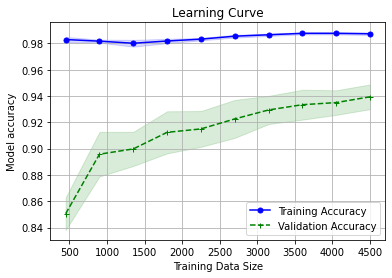

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt



# Use learning curve to get training and test scores along with train sizes
train_sizes, train_scores, test_scores = learning_curve(classifier, feature_matrix_test,y=classifier.predict(feature_matrix_test),
                                                       cv=10, train_sizes=np.linspace(0.1, 1.0, 10),
                                                       n_jobs=1)

# Calculate training and test mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


# Plot the learning curve
plt.figure().patch.set_facecolor('xkcd:white')
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

#Learning curve while using the whole data set

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

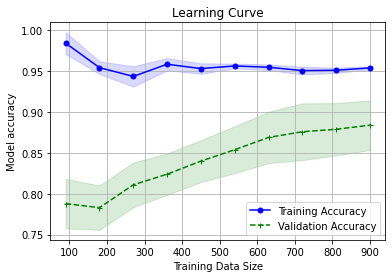

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn import datasets
import matplotlib.pyplot as plt



# Use learning curve to get training and test scores along with train sizes
train_sizes, train_scores, test_scores = learning_curve(classifier, feature_matrix_test,y=classifier.predict(feature_matrix_test),
                                                       cv=10, train_sizes=np.linspace(0.1, 1.0, 10),
                                                       n_jobs=1)

# Calculate training and test mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


# Plot the learning curve
plt.figure().patch.set_facecolor('xkcd:white')
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

#Learning curve while using only 1000 texts for data
#Surprisingly good results for only 1000, almost 90%!

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

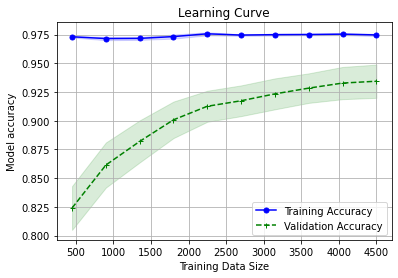

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn import datasets
import matplotlib.pyplot as plt



# Use learning curve to get training and test scores along with train sizes
train_sizes, train_scores, test_scores = learning_curve(classifier, feature_matrix_test,y=classifier.predict(feature_matrix_test),
                                                       cv=10, train_sizes=np.linspace(0.1, 1.0, 10),
                                                       n_jobs=1)

# Calculate training and test mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


# Plot the learning curve
plt.figure().patch.set_facecolor('xkcd:white')
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

#Learning curve while using only 5000 texts for data
#I tested with more varying amounts of data but didn't feel the need to include it all
#Seems like the sweet spot seems to be around 5000 data points, after 5000 it only improves VERY slightly